<a href="https://colab.research.google.com/github/asyam9/AIB17-discussion/blob/main/VGG19.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/ultralytics/ultralytics.git

Cloning into 'ultralytics'...
remote: Enumerating objects: 6103, done.
remote: Counting objects: 100% (350/350), done.
remote: Compressing objects: 100% (243/243), done.
remote: Total 6103 (delta 194), reused 213 (delta 107), pack-reused 5753
Receiving objects: 100% (6103/6103), 4.76 MiB | 15.83 MiB/s, done.
Resolving deltas: 100% (4095/4095), done.


In [ ]:
#MyDrive 내로 pwd 경로 변경
%cd 

In [ ]:
pip install jupyter

In [ ]:
pip install ultralytics

In [1]:
from keras.applications.vgg19 import VGG19
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.datasets import cifar10
from sklearn.model_selection import train_test_split
import os
import pandas as pd
import tensorflow as tf
from random import shuffle
import random
import torch
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision.transforms import Compose, Resize, ToTensor, Normalize
from tqdm import tqdm
import numpy as np
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

In [2]:
root = '/content/drive/MyDrive/data/mini_chest_xray/'
testRoot = root + 'test/'
trainRoot = root + 'train/'
nomal = 'NORMAL/'
pneumonia = 'PNEUMONIA/'

testNormal_Root = testRoot + nomal
testNormal_Names = os.listdir(testRoot + nomal)

testPneumonia_Root = testRoot + pneumonia
testPneumonia_Names = os.listdir(testRoot + pneumonia)

trainNormal_Root = trainRoot + nomal
trainNormal_Names = os.listdir(trainRoot + nomal)

trainPneumonia_Root = trainRoot + pneumonia
trainPneumonia_Names = os.listdir(trainRoot + pneumonia)


np.random.seed(42)
tf.random.set_seed(42)

In [3]:
def MakeArrayFromImage (testImage, size_x, size_y) :
  item = tf.keras.preprocessing.image.load_img(testImage, target_size=(size_x, size_y))
  item = tf.keras.preprocessing.image.img_to_array(item)
  item = tf.keras.applications.vgg19.preprocess_input(item)
  return item

def forMakeArray (imgRoot,imgNames, size_x, size_y) :
  arrayList = []
  for imageName in imgNames :
    item = MakeArrayFromImage(imgRoot + imageName, size_x, size_y)
    arrayList.append(item)
  return arrayList

In [4]:
size_x, size_y = 112, 112

testNormal_ImageList = forMakeArray(testNormal_Root, testNormal_Names, size_x, size_y)
testPneumonia_ImageList = forMakeArray(testPneumonia_Root, testPneumonia_Names, size_x, size_y)
trainNormal_ImageList = forMakeArray(trainNormal_Root, trainNormal_Names, size_x, size_y)
trainPneumonia_ImageList = forMakeArray(trainPneumonia_Root, trainPneumonia_Names, size_x, size_y)

In [5]:
len_trianN = len(trainNormal_ImageList)
len_trianP = len(trainPneumonia_ImageList)
len_testN = len(testNormal_ImageList)
len_testP = len(testPneumonia_ImageList)

X_train = np.array(trainNormal_ImageList + trainPneumonia_ImageList)
y_train = np.concatenate((np.zeros((len_trianN)), np.ones((len_trianP))),axis = 0) 

X_test = np.array(testNormal_ImageList + testPneumonia_ImageList)
y_test = np.concatenate((np.zeros((len_testN)), np.ones((len_testP))),axis = 0) 

del trainNormal_ImageList, trainPneumonia_ImageList, testNormal_ImageList, testPneumonia_ImageList

In [6]:
# X_train = np.array(X_train).astype('float32') / 255.
# X_test = np.array(X_test).astype('float32') / 255.

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=.2)

pretrained_model = VGG19(weights='imagenet', include_top=False)

80134624/80134624 [==============================] - 3s 0us/step


In [14]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models 
from tensorflow.keras.applications import VGG16

base = VGG19(weights= 'imagenet', include_top=False, input_shape = (112,112,3))
base.trainable = False

chpt = '/content/drive/MyDrive/data/checkPoint/'
modelName = 'vgg19_model.h5'

early_stopping = EarlyStopping(monitor='val_accuracy', patience=20)
checkpoint = ModelCheckpoint(chpt + modelName, save_best_only=True, save_weights_only=False, monitor='val_accuracy', verbose=1)


model = models.Sequential()
model.add(base)
model.add(layers.BatchNormalization())
model.add(layers.Flatten())
model.add(layers.Dense(64, activation = 'relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(64, activation = 'relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(64, activation = 'relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(64, activation = 'relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(64, activation = 'relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(64, activation = 'relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation = 'sigmoid'))

sgd = tf.keras.optimizers.SGD(learning_rate= 0.01, momentum = 0.9)
model.compile(optimizer = sgd, loss = 'binary_crossentropy',metrics = ['accuracy'])
epochs = 100

hist = model.fit(X_train, y_train, batch_size = 128, epochs= epochs , validation_data =(X_val,y_val), callbacks=[early_stopping, checkpoint])

Epoch 1/100
33/33 [==============================] - ETA: 0s - loss: 0.5815 - accuracy: 0.6867
Epoch 1: val_accuracy improved from -inf to 0.72302, saving model to /content/drive/MyDrive/data/checkPoint/vgg19_model.h5
33/33 [==============================] - 10s 231ms/step - loss: 0.5815 - accuracy: 0.6867 - val_loss: 0.3729 - val_accuracy: 0.7230
Epoch 2/100
33/33 [==============================] - ETA: 0s - loss: 0.2920 - accuracy: 0.8017
Epoch 2: val_accuracy improved from 0.72302 to 0.93792, saving model to /content/drive/MyDrive/data/checkPoint/vgg19_model.h5
33/33 [==============================] - 7s 219ms/step - loss: 0.2920 - accuracy: 0.8017 - val_loss: 0.2847 - val_accuracy: 0.9379
Epoch 3/100
33/33 [==============================] - ETA: 0s - loss: 0.2303 - accuracy: 0.9470
Epoch 3: val_accuracy improved from 0.93792 to 0.94365, saving model to /content/drive/MyDrive/data/checkPoint/vgg19_model.h5
33/33 [==============================] - 8s 260ms/step - loss: 0.2303 - accur

In [15]:
loss, acc = model.evaluate(X_test, y_test)

20/20 [==============================] - 1s 45ms/step - loss: 0.4759 - accuracy: 0.9103


In [16]:
best_epoch = np.argmax(hist.history['val_accuracy'])
model2 = tf.keras.models.load_model(chpt + modelName)

loss, acc = model2.evaluate(X_test, y_test)

20/20 [==============================] - 1s 44ms/step - loss: 0.5022 - accuracy: 0.8942


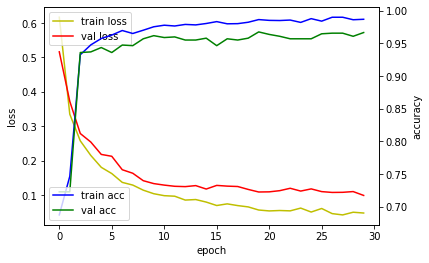

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

loss_ax.plot(hist.history['loss'],'y',label='train loss')
loss_ax.plot(hist.history['val_loss'],'r',label='val loss')
acc_ax.plot(hist.history['accuracy'],'b',label='train acc')
acc_ax.plot(hist.history['val_accuracy'],'g',label='val acc')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuracy')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')
plt.show()

20/20 [==============================] - 1s 36ms/step


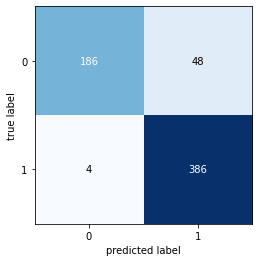

In [ ]:
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

y_pred = model.predict(X_test)
cm = confusion_matrix(y_test, np.round(y_pred))

fig, ax = plot_confusion_matrix(conf_mat=cm)
plt.show()